# SCEPTR Vector Alignment

In this notebook, we examine the alignment among the scoring layer weight vectors and classifying layer weight vectors for multiple runs. Specifically:

1. We gather the best epoch for each run.
2. For each run, load the model checkpoint and extract:
   - `scoring_linear1.weight` (shape `[1,64]`)
   - `classifying_linear1.weight` (shape `[1,64]`)
3. Compare them using angles (cosine similarity) within each run (scoring vs. classifying), and across runs (e.g. run i vs run j).

In [4]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import math
from pathlib import Path
import matplotlib.pyplot as plt

from src.model import load_trained, sceptr_unidirectional

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["figure.autolayout"] = True

import warnings
warnings.simplefilter("ignore")

## 1. Configuration
Adjust the `runs` dictionary so it maps each run index (0..9) to the best epoch. Then we’ll load each run’s checkpoint from `results-new-beta/sceptr/`.


In [5]:
# Suppose we have 10 runs (0..9), each with a best epoch that we found earlier.
runs = {
    0: 33,
    1: 49,
    2: 32,
    3: 20,
    4: 49,
    5: 10,
    6: 49,
    7: 43,
    8: 49,
    9: 49,
}

base_dir = Path.cwd() / "results-new-beta" / "sceptr"
model_dict = {}

for run_idx, best_epoch in runs.items():
    model_path = base_dir / f"trained-sceptr-{run_idx}" / f"Epoch {best_epoch}" / f"classifier-{best_epoch}.pth"
    model = load_trained(model_path, sceptr_unidirectional)
    model.eval()
    model_dict[run_idx] = model
    print(f"Loaded run={run_idx}, epoch={best_epoch}: {model_path}")

Loaded run=0, epoch=33: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-beta/sceptr/trained-sceptr-0/Epoch 33/classifier-33.pth
Loaded run=1, epoch=49: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-beta/sceptr/trained-sceptr-1/Epoch 49/classifier-49.pth
Loaded run=2, epoch=32: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-beta/sceptr/trained-sceptr-2/Epoch 32/classifier-32.pth
Loaded run=3, epoch=20: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-beta/sceptr/trained-sceptr-3/Epoch 20/classifier-20.pth
Loaded run=4, epoch=49: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-beta/sceptr/trained-sceptr-4/Epoch 49/classifier-49.pth
Loaded run=5, epoch=10: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-beta/sceptr/trained-sceptr-5/Epoch 10/classifier-10.pth
Loaded run=6, epoch=49: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-C

## 2. Compare Scoring vs. Classifying Weight Vector (Within Each Run)
For each run’s model, we’ll compute:
- Cosine similarity between `scoring_linear1.weight` and `classifying_linear1.weight`
- The angle in degrees


In [6]:
import math

run_scoring_classifying = {}

for run_idx, mdl in model_dict.items():
    # [1,64]
    w_scoring = mdl.scoring_linear1.weight.detach().cpu().numpy()[0]
    w_class   = mdl.classifying_linear1.weight.detach().cpu().numpy()[0]

    # Normalize
    w_scoring_n = w_scoring / (np.linalg.norm(w_scoring) + 1e-9)
    w_class_n   = w_class / (np.linalg.norm(w_class) + 1e-9)

    cos_sim = np.dot(w_scoring_n, w_class_n)
    angle   = math.degrees(math.acos(max(min(cos_sim,1),-1)))

    run_scoring_classifying[run_idx] = {
        'cosine_sim': cos_sim,
        'angle_deg': angle
    }

# Display the results
df_sc_class = pd.DataFrame(run_scoring_classifying).T
df_sc_class.index.name = 'run'
df_sc_class

,cosine_sim,angle_deg
run,,
0,-0.004381,90.250989
1,-0.055678,93.191763
2,0.038007,87.821839
3,-0.085505,94.905077
4,0.017943,88.971881
5,0.102254,84.131043
6,-0.136524,97.846748
7,-0.027768,91.591220
8,-0.093002,95.336336


## 3. Compare Scoring Vectors Across Runs
Let’s produce a matrix `[num_runs, num_runs]` of pairwise cosine similarities for the scoring layer. Then the same for the classifying layer.


In [7]:
run_indices = sorted(list(model_dict.keys()))
n_runs = len(run_indices)

score_mat = np.zeros((n_runs, n_runs))
class_mat = np.zeros((n_runs, n_runs))

# We'll store each scoring vector in a list so we don't keep re-extracting.
score_vectors = []  # shape [n_runs, 64]
class_vectors = []  # shape [n_runs, 64]

for r in run_indices:
    w_s = model_dict[r].scoring_linear1.weight.detach().cpu().numpy()[0]
    w_s /= (np.linalg.norm(w_s) + 1e-9)
    score_vectors.append(w_s)

    w_c = model_dict[r].classifying_linear1.weight.detach().cpu().numpy()[0]
    w_c /= (np.linalg.norm(w_c) + 1e-9)
    class_vectors.append(w_c)

score_vectors = np.array(score_vectors)
class_vectors = np.array(class_vectors)

for i in range(n_runs):
    for j in range(n_runs):
        # Dot product for scoring
        sc_cos = np.dot(score_vectors[i], score_vectors[j])
        score_mat[i,j] = sc_cos

        # Dot product for classifying
        cl_cos = np.dot(class_vectors[i], class_vectors[j])
        class_mat[i,j] = cl_cos

### 3.1: Visualize Cosine Similarity Matrices
We’ll just plot them as heatmaps. Values close to 1 mean the vectors are strongly aligned; negative means opposite directions.


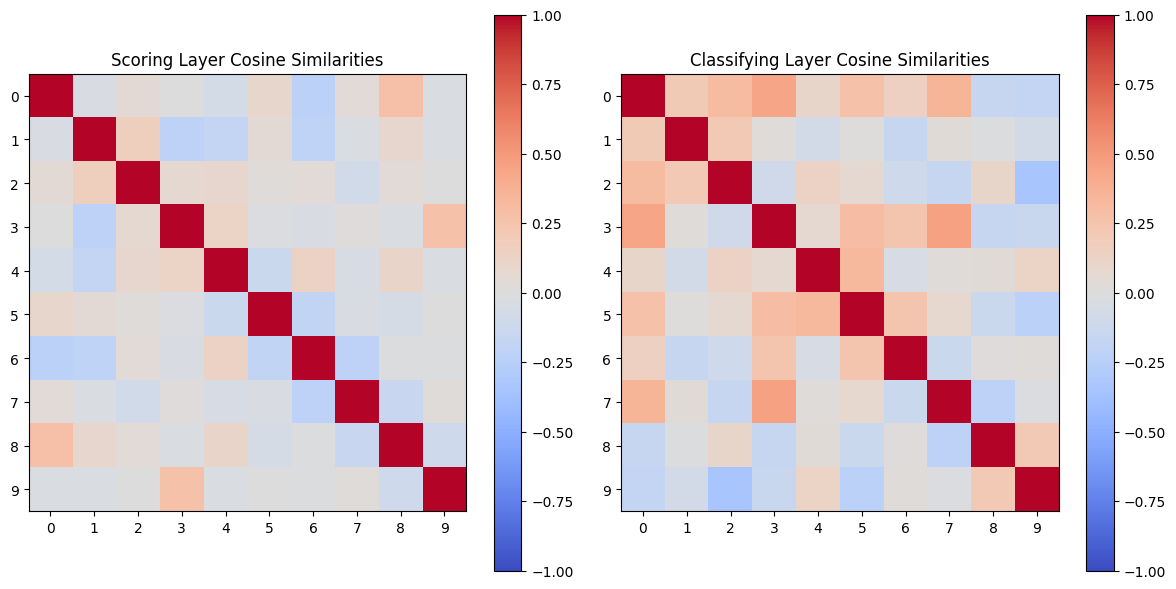

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
im0 = axs[0].imshow(score_mat, cmap="coolwarm", vmin=-1, vmax=1)
axs[0].set_title("Scoring Layer Cosine Similarities")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(class_mat, cmap="coolwarm", vmin=-1, vmax=1)
axs[1].set_title("Classifying Layer Cosine Similarities")
plt.colorbar(im1, ax=axs[1])

for ax in axs:
    ax.set_xticks(range(n_runs))
    ax.set_xticklabels(run_indices)
    ax.set_yticks(range(n_runs))
    ax.set_yticklabels(run_indices)

plt.show()

## 4. Bonus: If you want the angle matrix instead of just cos similarity
Angle in degrees is `acos(cos_sim)` * 180/pi. We can do that easily if you like. But the negative cos sims become angles > 90.  We’ll skip it for brevity, but you can add it.


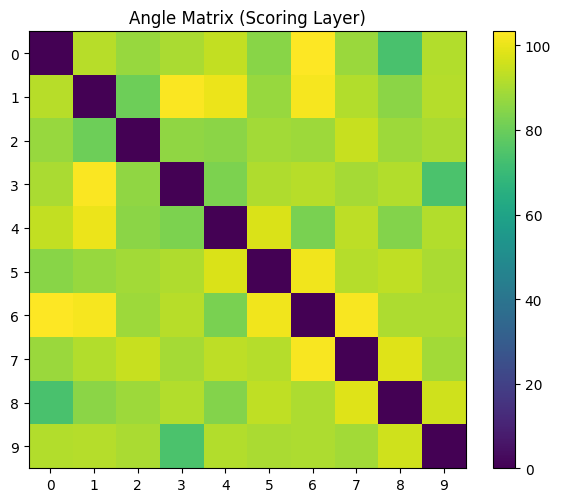

In [9]:
# Example of angle matrix for scoring layer
score_angle_mat = np.zeros_like(score_mat)
for i in range(n_runs):
    for j in range(n_runs):
        val = score_mat[i,j]
        # clamp in [-1,1]
        val = max(-1.0, min(1.0, val))
        score_angle_mat[i,j] = math.degrees(math.acos(val))

plt.figure(figsize=(6,5))
plt.imshow(score_angle_mat, cmap="viridis")
plt.title("Angle Matrix (Scoring Layer)")
plt.colorbar()
plt.xticks(range(n_runs), run_indices)
plt.yticks(range(n_runs), run_indices)
plt.show()

## 5. Conclusions
 - This notebook shows how the scoring and classifying vectors align **within** each run (scoring vs classifying), plus how the scoring vectors differ **across** runs.
 - If many runs converge to the same direction, you’ll see high similarity across them.
 - If the scoring vs. classifying angle is small, that means they point roughly the same way, i.e. the aggregator’s weighting dimension lines up with the final classification dimension.
